In [ ]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git

# ! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# # (use --upgrade --force-reinstall to upgrade)

# ! pip install scikit-image
# ! pip install matplotlib
# ! pip install opencv-python

In [3]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)
print(torch. cuda. is_available())
print("CUDA version:", torch.version.cuda)

Torch version: 2.2.2+cu118
True
CUDA version: 11.8


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [1]:
import clip

model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

ModuleNotFoundError: No module named 'clip'

In [4]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import json

def vid_path(filename):
    return f'./data/video/train/{filename}'

def load_video(filename):
    cap = cv2.VideoCapture(filename)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return np.array(frames)

def load_utt(vid_no, utt_no, text_data):
    utt = text_data[vid_no]['conversation'][utt_no-1]
    vid = load_video(vid_path(utt['video_name']))
    return vid, utt

def frame_to_img(frame):
    # frame = Image.fromarray(frame).convert("RGB")
    # frame = Image.fromarray(np.array(frame)[:, :, ::-1])
    
    frame = Image.fromarray(frame[:, :, ::-1])
    return  frame

with open('data/Subtask_2_train.json') as f:
    text_data_list = json.load(f)
    # text data is a map of conversation id to conversation
    text_data = {text['conversation_ID']: text for text in text_data_list}

Sorry I am late , I was stuck at work . There was this big dinosaur ... thing ... anyway .


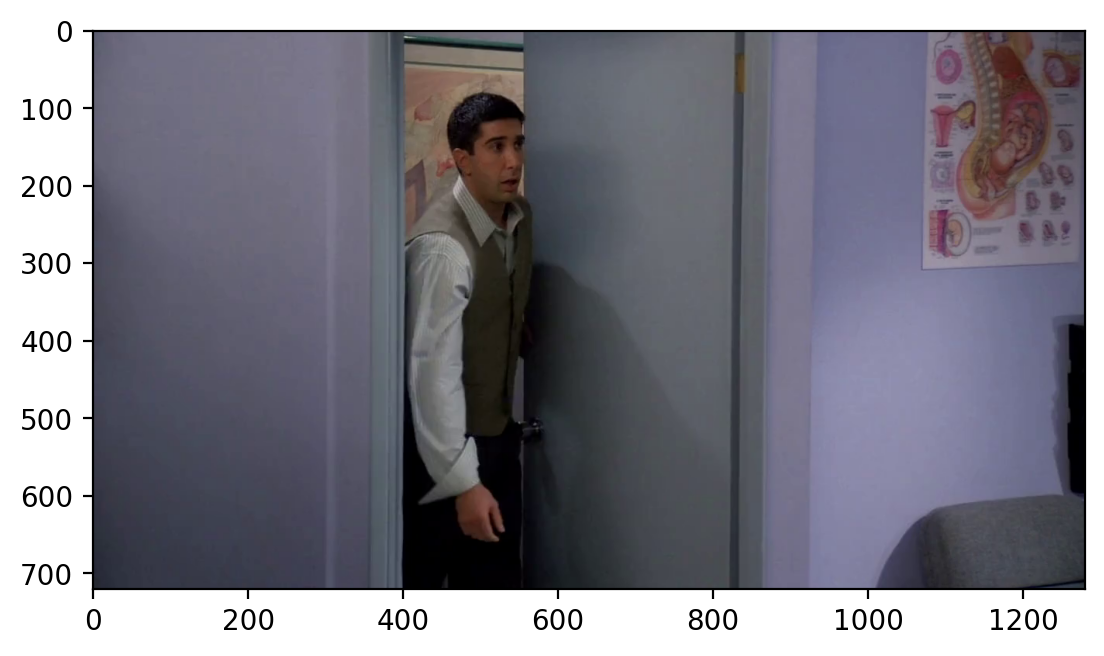

In [6]:
vid, utt = load_utt(8, 1, text_data)
print(utt['text'])
img = frame_to_img(vid[0])
np.array(img).shape
plt.imshow(img)
# img = preprocess(img)

In [7]:
def get_frame_first(vid, axis=0, resize_n=224):
    frame = cv2.resize(vid[0], (resize_n,resize_n))
    return frame

def get_frame_half(vid, axis=0, resize_n=224):
    frame = cv2.resize(vid[len(vid)//2], (resize_n,resize_n))
    return frame

def get_frame_last(vid, axis=0, resize_n=224):
    frame = cv2.resize(vid[-1], (resize_n,resize_n))
    return frame

def get_comic_3(vid, axis=0, resize_n=224):
    comic_frames = [
        vid[0],  # start
        vid[len(vid)//2],
        vid[-1],  # end
    ]

    comic_frames = [cv2.resize(frame, (resize_n,resize_n)) for frame in comic_frames]

    if axis == 0:
        comic = np.zeros((resize_n*3, 224, 3), dtype=np.uint8)
        comic[:resize_n] = comic_frames[0]
        comic[resize_n:resize_n*2] = comic_frames[1]
        comic[resize_n*2:] = comic_frames[2]
    elif axis == 1:
        comic = np.zeros((resize_n, resize_n*3, 3), dtype=np.uint8)
        comic[:, :resize_n] = comic_frames[0]
        comic[:, resize_n:resize_n*2] = comic_frames[1]
        comic[:, resize_n*2:] = comic_frames[2]

    return comic

def get_comic_4(vid, resize_n=512):
    comic_frames = [
        vid[0],  # start
        vid[len(vid)//3],
        vid[len(vid)*2//3],
        vid[-1]  # end
    ]

    comic_frames = [cv2.resize(frame, (resize_n,resize_n)) for frame in comic_frames]

    comic = np.zeros((resize_n*2, resize_n*2, 3), dtype=np.uint8)
    comic[:resize_n, :resize_n] = comic_frames[0]
    comic[:resize_n, resize_n:] = comic_frames[1]
    comic[resize_n:, :resize_n] = comic_frames[2]
    comic[resize_n:, resize_n:] = comic_frames[3]

    return comic

frame_funcs = [get_frame_first, get_frame_half, get_frame_last, get_comic_3, get_comic_4]

Oh , look , wish me luck !


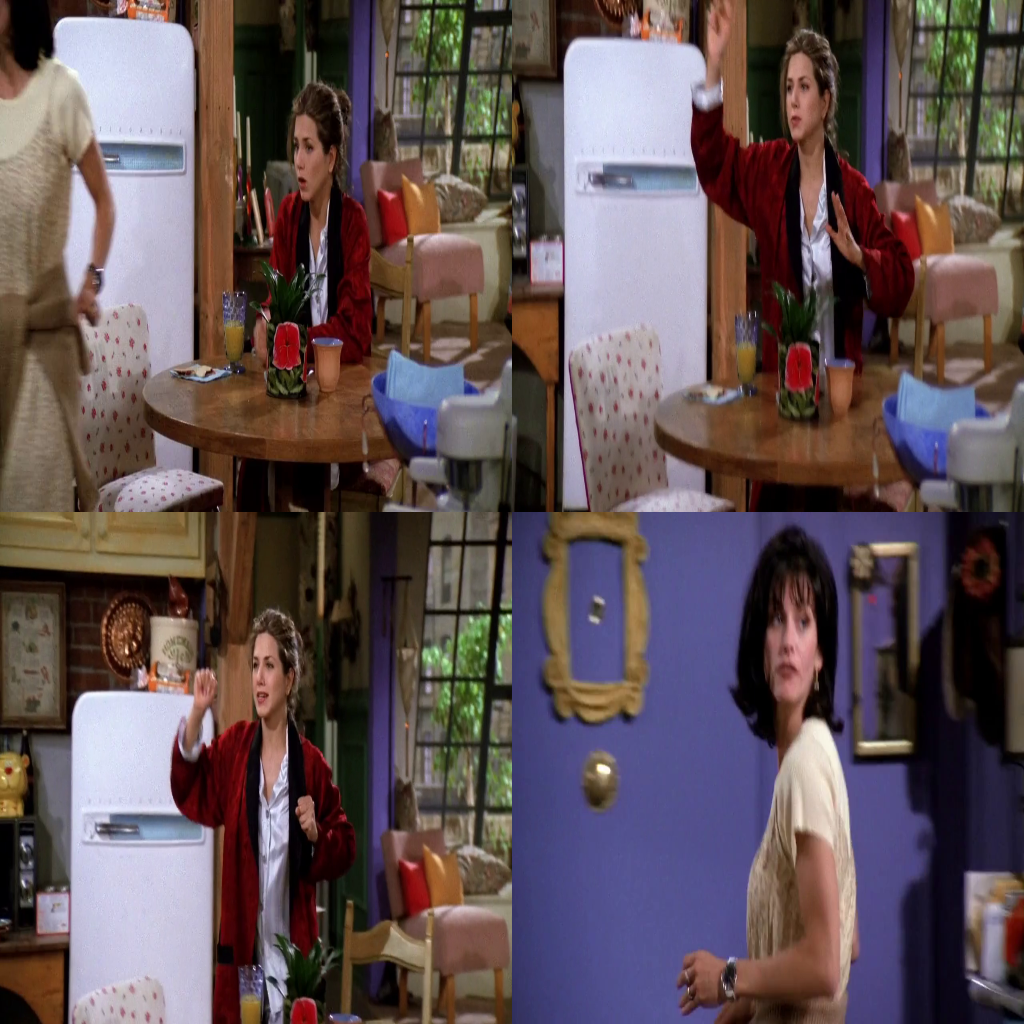

In [11]:
vid, utt = load_utt(5, 1, text_data)

# comic = get_comic_3(vid, axis=0)
comic = get_comic_4(vid)
comic = frame_to_img(comic)

print(utt['text'])
comic

### Preprocess all images

In [9]:
len(text_data)

1374

In [194]:
# import os

# for frame_func in frame_funcs:
#     path = f'./data/preproc_test/{frame_func.__name__[4:]}'
#     os.mkdir(path)

In [191]:
vid, utt = load_utt(18, 1, text_data)
# check if vid is empty
vid.size == 0


True

In [195]:
import time

n_images = 200

start = time.time()
missed_convs = []

for c_i in list(text_data.keys()):
    conv_dict = text_data[c_i]
    if (c_i-1) % 10 == 0:
        print(f"[{round(time.time()-start, 2)}s] conv {c_i}")
    for utt_dict in conv_dict['conversation']:
        u_i = utt_dict['utterance_ID']

        vid, utt = load_utt(c_i, u_i, text_data)
        if vid.size == 0:
            missed_convs.append(c_i)
            continue

        for frame_func in frame_funcs:
            fname_jpg = utt_dict['video_name'][:-4] + '.jpg'
            path = f'./data/preproc/{frame_func.__name__[4:]}/{fname_jpg}'
                
            # print(f"Preprocessing {frame_func.__name__[4:]}/{fname_jpg}")
            try:
                comic = frame_func(vid)
                comic = frame_to_img(comic)
                # # comic = preprocess(comic) # this preproc will be done at the time of inference
                # # save_image(comic, path)
                # print(f"Saving {frame_func.__name__[4:]}/{fname_jpg}")
                comic.save(path)
            except Exception as e:
                print(f"Error: {frame_func.__name__[4:]}/{fname_jpg}")
                raise e


[0.0s] conv 1


KeyboardInterrupt: 

In [146]:
conv_x_utt = 0
for conv in list(text_data.items()):
    conv_x_utt += len(conv[1]['conversation'])

print("Utt count from text_data", conv_x_utt)

Utt count from text_data 13619


In [139]:
preproc_path = './data/preproc/'
preproc_folders = os.listdir(preproc_path)
print("Image counts in folders")
for folder in preproc_folders:
    print(folder, len(os.listdir(preproc_path+folder)))

Image counts in folders
comic_3 9814
comic_4 9814
frame_first 9814
frame_half 9814
frame_last 9814
